In [11]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# plotting style
sns.set(style="darkgrid")
RANDOM_STATE = 42


In [12]:
# Path relative to /notebooks
DATA_PATH = '../data/boston.csv'
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
# Try to coerce numeric columns (safe)
df = df.apply(pd.to_numeric, errors='coerce')
print("Loaded dataset shape:", df.shape)
df.head()


Loaded dataset shape: (506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2


In [13]:
# Basic info
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Summary stats
df.describe().T


Columns: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']

Data types:
 CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object

Missing values:
 CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


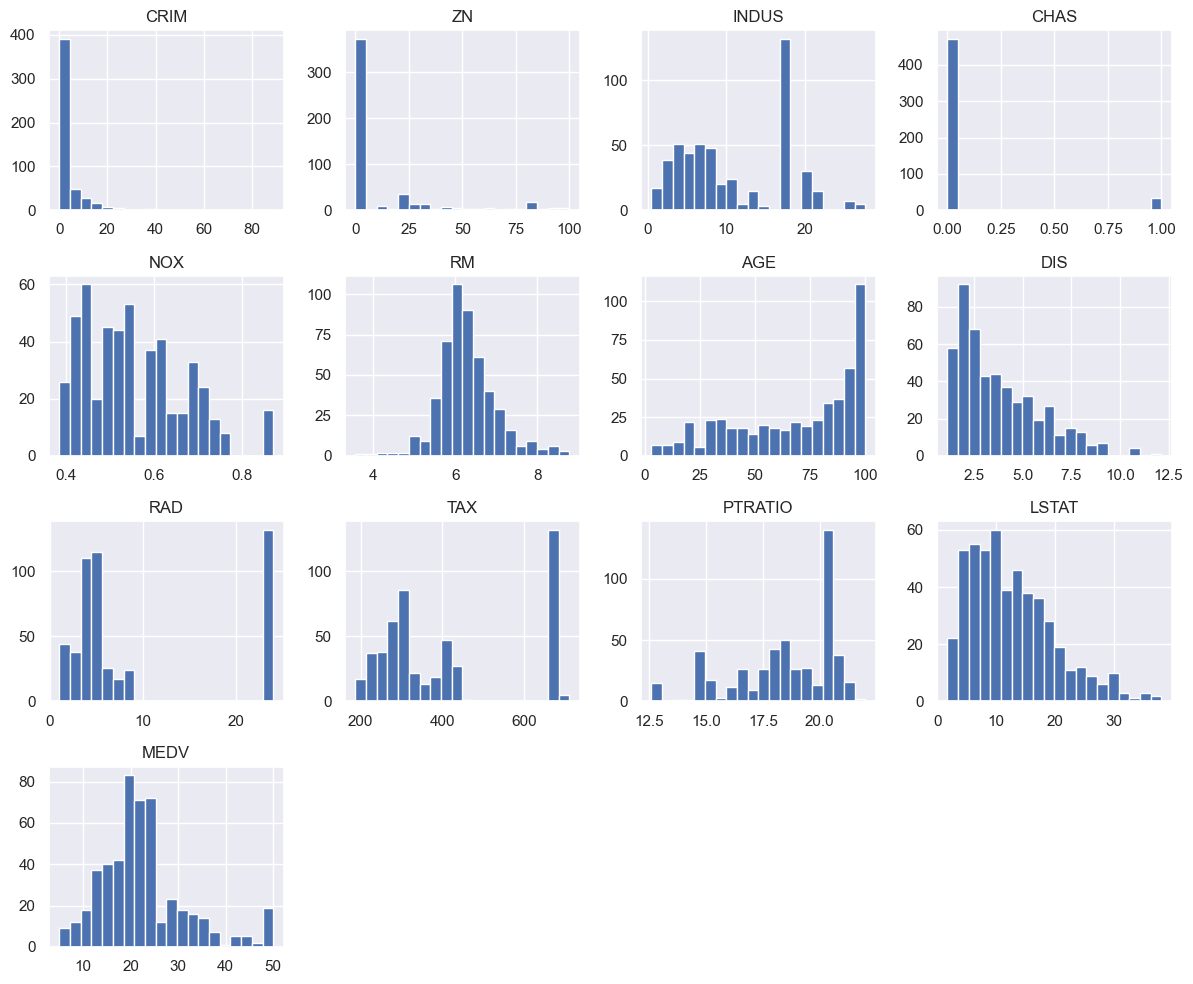

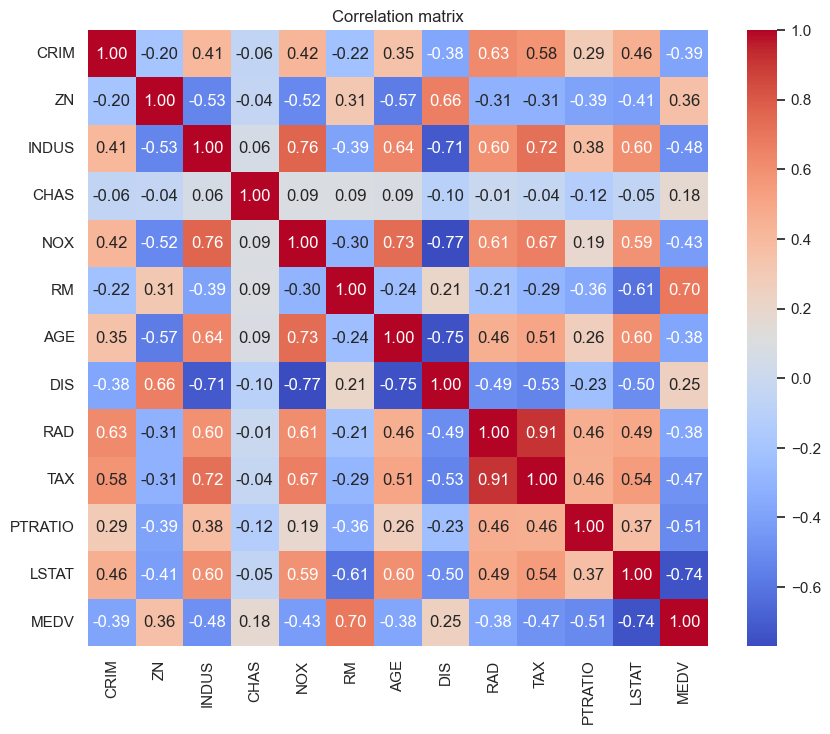

In [14]:
# Histograms for all numeric columns
df.hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()


In [15]:
# If any missing values, fill with median (simple robust approach)
if df.isnull().sum().sum() > 0:
    print("Filling missing values with column medians...")
    df = df.fillna(df.median())

# Ensure no missing remain
print("Missing values after fill:\n", df.isnull().sum().sum())

# Confirm numeric dtypes
print(df.dtypes)


Missing values after fill:
 0
CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object


In [16]:
# target: 'MEDV' — adjust if your file uses other name (common is MEDV)
TARGET = 'MEDV'
assert TARGET in df.columns, f"Target column '{TARGET}' not found"

X = df.drop(TARGET, axis=1)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (404, 12) Test shape: (102, 12)


In [17]:
# Linear Regression: use StandardScaler in pipeline
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Random Forest: tree-based (scaler not required but safe to keep a pipeline)
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE))
])

models = {
    "Linear Regression": pipe_lr,
    "Random Forest": pipe_rf
}


In [18]:
cv_results = []
for name, mdl in models.items():
    print(f"Cross-validating: {name} ...")
    # Use R² and neg MSE
    scores_r2 = cross_val_score(mdl, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    scores_mse = cross_val_score(mdl, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_results.append({
        'Model': name,
        'CV R2 Mean': np.mean(scores_r2),
        'CV R2 Std': np.std(scores_r2),
        'CV RMSE Mean': np.sqrt(-np.mean(scores_mse))
    })
    
cv_df = pd.DataFrame(cv_results)
cv_df


Cross-validating: Linear Regression ...
Cross-validating: Random Forest ...


,Model,CV R2 Mean,CV R2 Std,CV RMSE Mean
0,Linear Regression,0.714673,0.062464,4.939648
1,Random Forest,0.826244,0.050230,3.857585


In [19]:
results = []
for name, mdl in models.items():
    print(f"Fitting & evaluating: {name}")
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    results.append({
        "Model": name,
        "Test RMSE": rmse,
        "Test MSE": mse,
        "Test R2": r2
    })

results_df = pd.DataFrame(results).sort_values(by="Test R2", ascending=False)
results_df


Fitting & evaluating: Linear Regression
Fitting & evaluating: Random Forest


,Model,Test RMSE,Test MSE,Test R2
1,Random Forest,2.829899,8.008327,0.890796
0,Linear Regression,4.772600,22.777709,0.689397


In [20]:
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 8, 15],
    'rf__min_samples_split': [2, 5]
}

grid = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best RF params:", grid.best_params_)
print("Best RF CV R2:", grid.best_score_)

# Evaluate tuned RF on test set
best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("RF tuned Test R2:", r2_score(y_test, y_pred_rf))
print("RF tuned Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RF params: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best RF CV R2: 0.8262443886181486
RF tuned Test R2: 0.8907962174500659
RF tuned Test RMSE: 2.8298986748298827


In [24]:
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
tuned_mse = mean_squared_error(y_test, y_pred_rf)
tuned_r2 = r2_score(y_test, y_pred_rf)
tuned_row_df = pd.DataFrame([{
    "Model": "Random Forest (tuned)",
    "Test RMSE": tuned_rmse,
    "Test MSE": tuned_mse,
    "Test R2": tuned_r2
}])

# Find rows with "Random Forest"
rf_mask = results_df["Model"] == "Random Forest"

# Filter existing RF rows
existing_rf = results_df[rf_mask]

# Prepare DataFrame excluding "Random Forest" rows
df_wo_rf = results_df[~rf_mask]

# Compare tuned R2 with existing RF max R2 (or -inf if none)
max_rf_r2 = existing_rf["Test R2"].max() if not existing_rf.empty else float('-inf')

# If tuned_r2 better, replace all "Random Forest" rows by tuned_row_df, else keep existing_rf
replaced_rf = tuned_row_df if tuned_r2 > max_rf_r2 else existing_rf

# Combine back and sort
results_df = pd.concat([df_wo_rf, replaced_rf], ignore_index=True).sort_values(by="Test R2", ascending=False).reset_index(drop=True)

results_df

,Model,Test RMSE,Test MSE,Test R2
0,Random Forest,2.829899,8.008327,0.890796
1,Linear Regression,4.772600,22.777709,0.689397


In [25]:
# Choose best model based on Test R2 (or CV)
best_row = results_df.iloc[0]
best_name = best_row['Model']
print("Best model selected:", best_name)

if best_name.startswith("Random Forest (tuned)"):
    best_model = best_rf
elif best_name.startswith("Random Forest"):
    # if baseline RF better
    # train fresh RF on entire training set
    rf = RandomForestRegressor(random_state=RANDOM_STATE)
    rf.fit(X_train, y_train)
    best_model = rf
else:
    # Linear Regression pipeline: fit to training
    pipe_lr.fit(X_train, y_train)
    best_model = pipe_lr

# Final evaluation: actual vs predicted
y_pred_best = best_model.predict(X_test)
print("Final Test R2:", r2_score(y_test, y_pred_best))
print("Final Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))


Best model selected: Random Forest
Final Test R2: 0.8907962174500659
Final Test RMSE: 2.8298986748298827


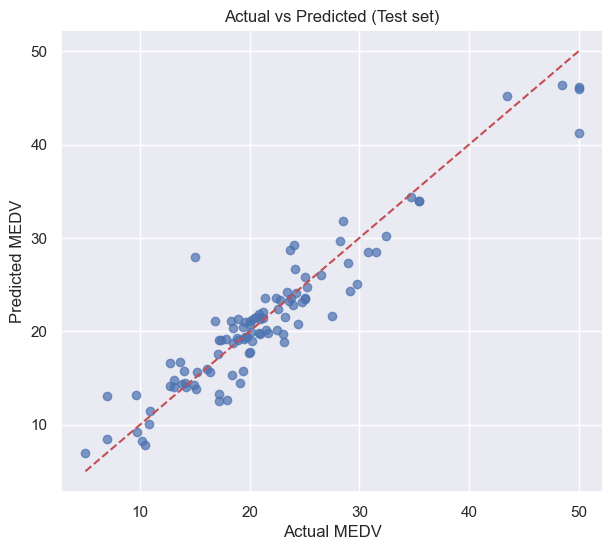

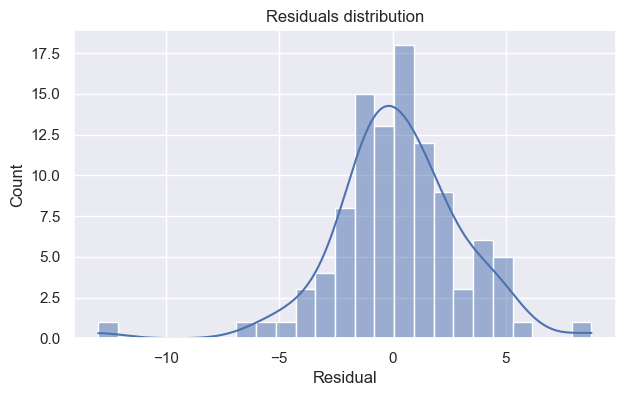

In [26]:
# Actual vs Predicted
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted (Test set)")
plt.show()

# Residuals
residuals = y_test - y_pred_best
plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=25, kde=True)
plt.title("Residuals distribution")
plt.xlabel("Residual")
plt.show()


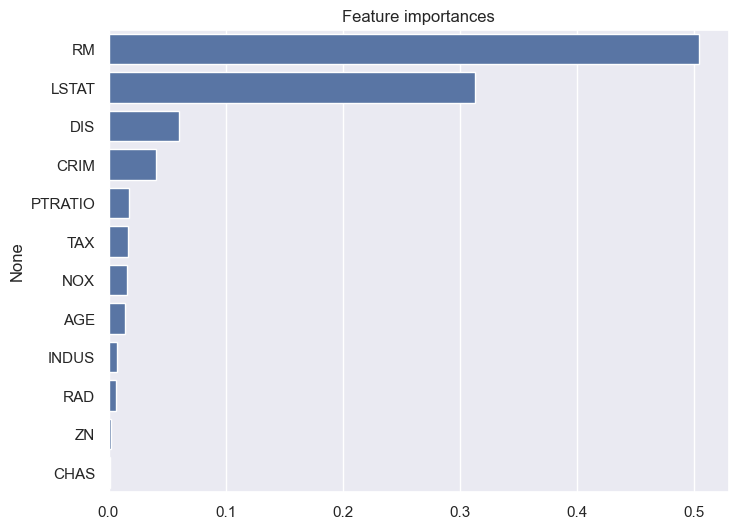

In [27]:
# If the best model has feature importances (RandomForest), show them
if hasattr(best_model, 'named_steps') and 'rf' in best_model.named_steps:
    rf_model = best_model.named_steps['rf']
    importances = rf_model.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances (Random Forest)")
    plt.show()
elif hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances")
    plt.show()
else:
    print("Best model has no feature_importances_ attribute (likely Linear Regression pipeline).")


In [28]:
MODEL_PATH = '../model.pkl'
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Saved best model ({best_name}) to: {MODEL_PATH}")

# Quick check: try loading back
with open(MODEL_PATH, 'rb') as f:
    test_load = pickle.load(f)
print("Loaded model type:", type(test_load))


Saved best model (Random Forest) to: ../model.pkl
Loaded model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [29]:
# Save a CSV of evaluation results to repo
results_df.to_csv('../model_comparison_results.csv', index=False)
print("Saved model comparison CSV to ../model_comparison_results.csv")

# Notes for Streamlit app:
print("""
Notes:
- Place this ../model.pkl in project root next to app.py (Streamlit).
- Streamlit will load using pickle.load(open('model.pkl','rb')).
- If you use a pipeline (e.g., scaler + LR), the pipeline handles scaling when predicting.
""")


Saved model comparison CSV to ../model_comparison_results.csv

Notes:
- Place this ../model.pkl in project root next to app.py (Streamlit).
- Streamlit will load using pickle.load(open('model.pkl','rb')).
- If you use a pipeline (e.g., scaler + LR), the pipeline handles scaling when predicting.

